# Loading images and image preprocessing

In [1]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2020-07-17 08:27:35--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   106MB/s    in 0.6s    

2020-07-17 08:27:36 (106 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
train_dir = '/tmp/cats_and_dogs_filtered/train'
validation_dir = '/tmp/cats_and_dogs_filtered/validation'

train_cats_dir = os.path.join(train_dir, 'cats') 
train_dogs_dir = os.path.join(train_dir, 'dogs') 
validation_cats_dir = os.path.join(validation_dir, 'cats') 
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Adding our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                   rotation_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Flow training images in batches of 20
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size = 20,
                                                        class_mode = 'binary',
                                                        target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Loading Inception Model

In [5]:
# inception model weights

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-07-17 08:27:41--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   134MB/s    in 0.6s    

2020-07-17 08:27:42 (134 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [6]:
import os
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3

load_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(load_weights_file)

In [7]:
# last layer
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


# Building Model on top of pre_trained_model

In [8]:
x = tf.keras.layers.Flatten()(last_output)

x = tf.keras.layers.Dense(1024, activation='relu')(x)

x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(pre_trained_model.input, x)

In [9]:
# model.summary()

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [11]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 20,
                    verbose = 1)

Epoch 1/20
100/100 [==============================] - 30s 299ms/step - loss: 0.3621 - accuracy: 0.8335 - val_loss: 0.1862 - val_accuracy: 0.9590
Epoch 2/20
100/100 [==============================] - 29s 289ms/step - loss: 0.1926 - accuracy: 0.9210 - val_loss: 0.2059 - val_accuracy: 0.9580
Epoch 3/20
100/100 [==============================] - 29s 286ms/step - loss: 0.1313 - accuracy: 0.9425 - val_loss: 0.3372 - val_accuracy: 0.9480
Epoch 4/20
100/100 [==============================] - 29s 290ms/step - loss: 0.0901 - accuracy: 0.9695 - val_loss: 0.6579 - val_accuracy: 0.9220
Epoch 5/20
100/100 [==============================] - 29s 286ms/step - loss: 0.1008 - accuracy: 0.9655 - val_loss: 0.2630 - val_accuracy: 0.9650
Epoch 6/20
100/100 [==============================] - 29s 289ms/step - loss: 0.1016 - accuracy: 0.9715 - val_loss: 0.3086 - val_accuracy: 0.9530
Epoch 7/20
100/100 [==============================] - 29s 287ms/step - loss: 0.0883 - accuracy: 0.9815 - val_loss: 0.2179 - val_ac

# Visualizing model accuracy

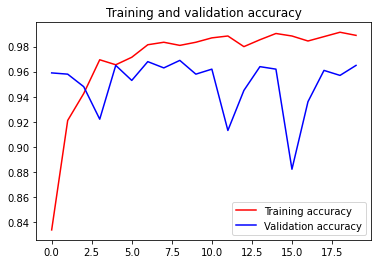

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()